I decided to do my project on Formula 1(F1), a motor sport competition overseen by the FIA. I've always had a interest in F1, and one part of it that always interested me was the strategy decisions made by the teams. A wheel crafted pit stop strategy can make or break a race, turning race wins to barely finishing in the points, or barely finishing in the points to a race win if your competitors make a slip up. I decided to use this project to try to predict the most ideal number of pitstops in order to secure a podium finish.
The first thing I began on in this project was research into the area in question, i.e., F1 pitstop strategy. I went into this knowing that F1 strategy decisions could be at best described as tricky, and knowing that a number of factors affected tire wear, but through my research, the full difficulty of predicting these races became clear. Obviously, you have your standard turns differing on each race track affecting different tires, but issues such as track temperature compared to allowed tire blanket temperatures is one of the many issues which I had not accounted for, as the FIA change the allowed temperature seemingly from year to year. After concluding this research, I realised that it wouldn’t really be possible to account for every possible cause of tire wear, so I settled for taking previous f1 seasons winners pitstops, intending to train a model to predict this year’s winners. I got my dataset from Kaggle, which can be found [Here.](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)

I used these as my research material:

1. This artiicle by F1 themselves explains the intricacies and training required to pull off a quick pit stop. https://www.formula1.com/en/latest/article/gone-in-1-88s-putting-together-the-perfect-f1-pit-stop.3lLKnEoPKdJgACsUn9IltC
2.  This article better illustates the delicate balance between spped and percision required for a pit stop, and how reacting to on track conditons, such as a saftey car, makes a huge difference https://statathlon.com/analysis-of-the-pit-stop-strategy-in-f1/
3. This articile better analyese the rules and regulations around pit stops and the pit lane :https://www.nationalworld.com/sport/formula-1/f1-pit-stops-rules-pit-lane-stop-crew-roles-longest-pitstop-formula-1-history-4076807
4. This article goes into how tire degredation is caused and why it is different per circuit: https://www.catapult.com/blog/how-tyre-degradation-affects-race-strategy#:~:text=There%20are%20three%20main%20causes,%3A%20wear%2C%20temperature%20and%20pressure.

In addition to this, as an avid F1 fan i came in with a relatively strong knowledge




This code Block is used to setup filepaths and import the required libaries which will be used for this project. I also added all the merges her to enusre clenaliness of the code, and set up my API cache.

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

#from google.colab import files
#uploaded = files.upload()

# Install packages
!pip install openmeteo-requests
!pip install retry-requests
!pip install requests-cache

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests_cache
import sklearn as skb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from retry_requests import retry
import time
import openmeteo_requests




# Define file paths
filePathPitStops = "/content/drive/MyDrive/Colab Notebooks/DataAnalysisProject/pit_stops.csv"
filePathDrivers = "/content/drive/MyDrive/Colab Notebooks/DataAnalysisProject/drivers.csv"
filePathCircuits = "/content/drive/MyDrive/Colab Notebooks/DataAnalysisProject/circuits.csv"
filePathResults = "/content/drive/MyDrive/Colab Notebooks/DataAnalysisProject/results.csv"
filePathRaces = "/content/drive/MyDrive/Colab Notebooks/DataAnalysisProject/races.csv"

# Load data in using pandas
dfPitStops = pd.read_csv(filePathPitStops)
dfDrivers = pd.read_csv(filePathDrivers)
dfCircuits = pd.read_csv(filePathCircuits)
dfResults = pd.read_csv(filePathResults)
dfRaces = pd.read_csv(filePathRaces)

# Merge dataframes together for use
df_results_races = pd.merge(dfResults, dfRaces, on='raceId', how='left')
df_results_races_drivers = pd.merge(df_results_races, dfDrivers, on='driverId', how='left')
df_results_races_drivers = df_results_races_drivers[df_results_races_drivers['year'] >= 2011]
df_winners = df_results_races_drivers[df_results_races_drivers['points'] == 25]
df_winners_pitstops = pd.merge(df_winners, dfPitStops, on=['raceId', 'driverId'], how='left')
df_winners_pitstops = pd.merge(df_winners_pitstops, dfCircuits[['circuitId', 'name']], on='circuitId', how='left')
df_winners_circuits = pd.merge(df_winners_pitstops, dfCircuits[['circuitId', 'name']], on='circuitId', how='left')

# Setting up Pitstop _counts
pitstop_counts = df_winners_pitstops.groupby(['forename', 'surname'])['stop'].count().reset_index()
pitstop_counts = pd.merge(pitstop_counts, df_winners[['driverId', 'forename', 'surname']], on=['forename', 'surname'], how='left')
idx = pitstop_counts['stop'].idxmax()
pitstop_counts = pitstop_counts.loc[[idx]]
pitstop_counts = pitstop_counts.rename(columns={'name': 'Circuit', 'forename': 'Winner_Forename', 'surname': 'Winner_Surname', 'stop': 'Number_of_Pitstops'})

# Merging Pitstop Data
df_winners_pitstops_filtered = df_winners_pitstops[df_winners_pitstops['year'] >= 2011]
max_pitstops_per_race = df_winners_pitstops_filtered.groupby(['raceId', 'name_y'])['stop'].max().reset_index()
max_pitstops_per_race = pd.merge(max_pitstops_per_race, dfRaces[['raceId', 'year']], on='raceId', how='left')
max_pitstops_per_race = pd.merge(max_pitstops_per_race, df_winners[['raceId', 'forename', 'surname']], on='raceId', how='left')
max_pitstops_per_race = pd.merge(max_pitstops_per_race, dfRaces[['raceId', 'date']], on='raceId', how='left')

# Set up requests-cache for API
requests_cache.install_cache('openmeteo_cache', backend='sqlite', expire_after=180)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I set Up some methods here in an effort to make some code blocks shorter.
1.display_winners(): Is used to iterate over the df_winners_circuits to show the winners of each circuit by year

2.display_Max_Pitstops(): Is used to iterate over the df_winners_circuits to show the winners of each circuit by year as well as the max Pit Stops

3.get_Circuit_coordinates() Is used to call the api to get the circuits latitude and longitude.

4.retry (): Is used to setup the retries for the weather api, added due to an updated api requirement

5.get_weather_data(): Is used to check the weather from the api on the date of the race

This code block was added later in the project in an effort to keep my code clean and easier to read, so some legacy code may remain in the code.









In [ ]:
#Is used to itterate over the df_winners_circuits to show thw winners of each circuit by year
def display_winners(df_winners_circuits):
    for index, row in df_winners_circuits.iterrows():
        print(f"Race: {row['name_y']}, Winner: {row['forename']} {row['surname']}, Circuit: {row['name_x']}, Date: {row['date']}")

#Is used to itterate over the df_winners_circuits to show the winners of each circuit by year aswell as the max Pit Stops
def display_Max_Pitstops(max_pitstops_per_race):
  for index, row in max_pitstops_per_race.iterrows():
    print(f"Race: {row['name_y']}, Pitstops: {row['stop']}, Year: {row['year']}, Winner: {row['forename']} {row['surname']}")

def get_circuit_coordinates(circuit_name, dfCircuits):
  circuit_data = dfCircuits[dfCircuits['name'] == circuit_name]
  if not circuit_data.empty:
    latitude = circuit_data['lat'].iloc[0]
    longitude = circuit_data['lng'].iloc[0]
    return latitude, longitude
  else:
    print(f"Circuit data not found for {circuit_name}")
    return None, None

def retry(session, retries, backoff_factor):
    from requests.adapters import HTTPAdapter
    from requests.packages.urllib3.util.retry import Retry

    retry_strategy = Retry(
        total=retries,
        backoff_factor=backoff_factor,
        status_forcelist=[429, 500, 502, 503, 504],
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    return session

def get_weather_data(latitude, longitude, race_date):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)

    url = "https://archive-api.open-meteo.com/v1/archive"

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": race_date,
        "end_date": race_date,
        "hourly": "temperature_2m,rain"
    }

    try:
        # Send a request to Open-Meteo API
        response = retry_session.get(url, params=params)

        if response.status_code == 200:
            data = response.json()
            hourly = data.get('hourly', {})

            # Get temperature and rain data
            hourly_temperature_2m = hourly.get('temperature_2m', [])
            hourly_rain = hourly.get('rain', [])

            # Calculate daily averages
            avg_temperature_2m = sum(hourly_temperature_2m) / len(hourly_temperature_2m) if hourly_temperature_2m else 0
            total_rain = sum(hourly_rain) if hourly_rain else 0

            daily_data = {
                "date": race_date,
                "avg_temperature_2m": avg_temperature_2m,
                "total_rain": total_rain
            }

            # Create a DataFrame from the collected data
            daily_dataframe = pd.DataFrame([daily_data])
            return daily_dataframe
        else:
            print(f"Error: {response.status_code} - {response.text}")
            return None
    except Exception as e:
        print(f"Error retrieving weather data: {e}")
        return None

This was another addition later in the code, as I used it to bring the races weather into a singular data frame. This was done as I kept running into issues with the API having a maximum number of allowed requests, whereas the API to find the latitude and longitude did not have this issue.

In [ ]:


# Empty list to store weather data
weather_data = []

# Iterate over each race to get weather data
for index, row in max_pitstops_per_race.iterrows():
    circuit_name = row['name_y']
    race_date_str = str(row['date'])

    # Extract year, month, and day from the date string
    year, month, day = map(int, race_date_str.split('-'))
    start_date = f"{year}-{month:02d}-{day:02d}"
    end_date = f"{year}-{month:02d}-{day:02d}"

    # Get circuit coordinates for each circuit
    latitude, longitude = get_circuit_coordinates(circuit_name, dfCircuits)

    # Check to ensure latituide and longituide are not in the list already
    if latitude is not None and longitude is not None:
        hourly_data = get_weather_data(latitude, longitude, start_date)
        if hourly_data is not None:
            # Add circuit name and date to weather data
            hourly_data['circuit'] = circuit_name
            hourly_data['date'] = race_date_str

            # add the hourly data to the weather_data
            weather_data.append(hourly_data)

# Concatenate all weather data into a single DataFrame
if weather_data:
    weather_df = pd.concat(weather_data, ignore_index=True)

else:
    print("No weather data retrieved.")


Displays Race, Pitstops, Year and Winner.




In [ ]:
display_Max_Pitstops(max_pitstops_per_race)

Race: Albert Park Grand Prix Circuit, Pitstops: 2, Year: 2011, Winner: Sebastian Vettel
Race: Sepang International Circuit, Pitstops: 3, Year: 2011, Winner: Sebastian Vettel
Race: Shanghai International Circuit, Pitstops: 3, Year: 2011, Winner: Lewis Hamilton
Race: Istanbul Park, Pitstops: 4, Year: 2011, Winner: Sebastian Vettel
Race: Circuit de Barcelona-Catalunya, Pitstops: 4, Year: 2011, Winner: Sebastian Vettel
Race: Circuit de Monaco, Pitstops: 1, Year: 2011, Winner: Sebastian Vettel
Race: Circuit Gilles Villeneuve, Pitstops: 6, Year: 2011, Winner: Jenson Button
Race: Valencia Street Circuit, Pitstops: 3, Year: 2011, Winner: Sebastian Vettel
Race: Silverstone Circuit, Pitstops: 3, Year: 2011, Winner: Fernando Alonso
Race: Nürburgring, Pitstops: 3, Year: 2011, Winner: Lewis Hamilton
Race: Hungaroring, Pitstops: 3, Year: 2011, Winner: Jenson Button
Race: Circuit de Spa-Francorchamps, Pitstops: 3, Year: 2011, Winner: Sebastian Vettel
Race: Autodromo Nazionale di Monza, Pitstops: 2, Y

This code block shows the data in a bar chart.

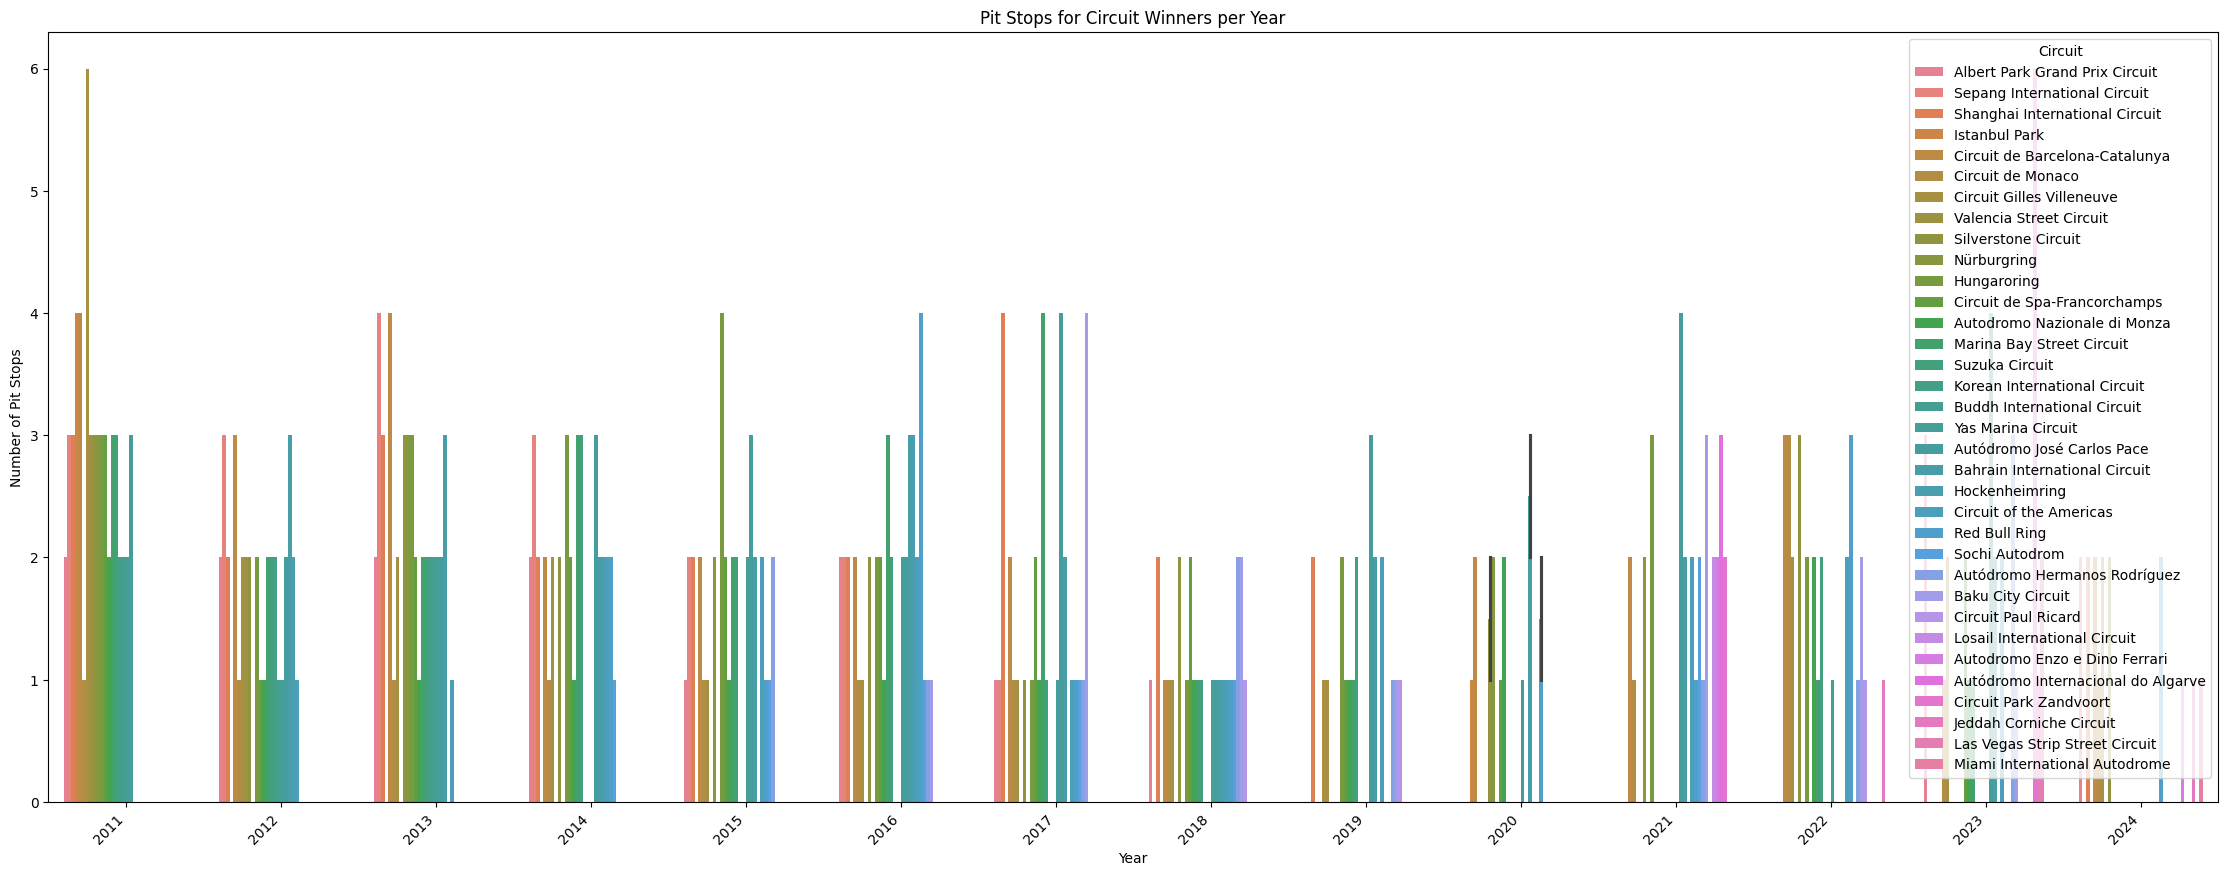

In [ ]:
plt.figure(figsize=(28, 10))
sns.barplot(x='year', y='stop', hue='name_y', data=max_pitstops_per_race)
plt.title('Pit Stops for Circuit Winners per Year')
plt.xlabel('Year')
plt.ylabel('Number of Pit Stops')
plt.legend(title='Circuit')
plt.xticks(rotation=45, ha='right')

plt.show()

This code block is used to find the weather for each circuit on the day of the race, and was my first use of an API I haven’t built myself. The API I used to get the weather is open momento and the link can be found [Here](https://open-meteo.com/en/docs/previous-runs-api). The reason I decided on this api was the fact it was free, whereas the others i found charged per API Call. The api worked well, and while issues with maximum allowed api calls did arise, I was able to fix this by putting it in a data frame.



In [ ]:
for index, row in max_pitstops_per_race.iterrows():
    circuit_name = row['name_y']
    race_year = row['year']
    race_date_str = row['date']

    # get circuit cordinates
    latitude, longitude = get_circuit_coordinates(circuit_name, dfCircuits)

    # Check if coordinates were found
    if latitude is not None and longitude is not None:
        #Gets the date out adjusted for api requirments
        start_date = str(race_year) + "-01-01"
        end_date = race_date_str

        # Limit end_date to the maximum allowed date
        max_allowed_date = pd.to_datetime("2024-11-13")
        end_date_dt = pd.to_datetime(end_date)

        if end_date_dt > max_allowed_date:
            end_date = max_allowed_date.strftime("%Y-%m-%d")

        # Call the API to get weather
        hourly_dataframe = get_weather_data(latitude, longitude, race_date_str)

        if hourly_dataframe is not None:
            # Ensure 'date' column is in datetime format
            hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])

            # Check if 'avg_temperature_2m' and 'total_rain' columns exist
            if 'avg_temperature_2m' in hourly_dataframe.columns and 'total_rain' in hourly_dataframe.columns:
                # Find the temperature and rain on the race day and calculate total using the API
                race_date = pd.to_datetime(race_date_str)
                weather_on_race_day = hourly_dataframe[hourly_dataframe['date'].dt.date == race_date.date()]
                if not weather_on_race_day.empty:
                    race_day_temperature = weather_on_race_day['avg_temperature_2m'].mean()
                    race_day_rain = weather_on_race_day['total_rain'].sum()

                    # Check rain conditions and determine tire type
                    tire_type = ""
                    if race_day_rain > 2:
                        tire_type = "Full Wets"
                    elif race_day_rain > 0.8:
                        tire_type = "Damp/Inters"
                    else:
                        tire_type = "Slicks"

                    # Print weather information with tire type
                    print(f"Race: {row['name_y']}, Max Pitstops: {row['stop']}, Year: {row['year']}, Winner: {row['forename']} {row['surname']}, "
                          f"Weather: {race_day_temperature}°C, Rain: {race_day_rain}mm, Tyre Type: {tire_type}")
                else:
                    print(f"Race: {row['name_y']}, Max Pitstops: {row['stop']}, Year: {row['year']}, Winner: {row['forename']} {row['surname']}, "
                          f"Weather: Not Found for date: {race_date_str}")
            else:
                print(f"Missing columns ('avg_temperature_2m' or 'total_rain') in weather data for {circuit_name}")
        else:
            print(f"Error retrieving weather data for {circuit_name}: ")

    else:
        print(f"Circuit data not found for {circuit_name}")


Race: Albert Park Grand Prix Circuit, Max Pitstops: 2, Year: 2011, Winner: Sebastian Vettel, Weather: 15.283333333333331°C, Rain: 0.0mm, Tyre Type: Slicks
Race: Sepang International Circuit, Max Pitstops: 3, Year: 2011, Winner: Sebastian Vettel, Weather: 24.929166666666664°C, Rain: 22.5mm, Tyre Type: Full Wets
Race: Shanghai International Circuit, Max Pitstops: 3, Year: 2011, Winner: Lewis Hamilton, Weather: 15.29166666666667°C, Rain: 0.0mm, Tyre Type: Slicks
Race: Istanbul Park, Max Pitstops: 4, Year: 2011, Winner: Sebastian Vettel, Weather: 11.1875°C, Rain: 0.0mm, Tyre Type: Slicks
Race: Circuit de Barcelona-Catalunya, Max Pitstops: 4, Year: 2011, Winner: Sebastian Vettel, Weather: 20.2°C, Rain: 0.0mm, Tyre Type: Slicks
Race: Circuit de Monaco, Max Pitstops: 1, Year: 2011, Winner: Sebastian Vettel, Weather: 19.116666666666667°C, Rain: 0.0mm, Tyre Type: Slicks
Race: Circuit Gilles Villeneuve, Max Pitstops: 6, Year: 2011, Winner: Jenson Button, Weather: 15.141666666666671°C, Rain: 23.3

After Getting the information, this code block uses the data to collate the different information on pitstops for different weather conditions. This is the section where the project became more difficult, as I was unable to predict exactly if the FIA would postpone a race depending on weather conditions. I came around this with further research and a general rule of thumb states if a race has more than .8mm of rain is considered inters, and more than 2 is full wet weather. While not perfect, it allowed me to continue the project given the best guess I could at the FIA's decision. I then averaged out the pitstops for each tire condition.

In [ ]:
# Create list to store average pitstops
average_pitstops = {}

for index, row in max_pitstops_per_race.iterrows():
    circuit_name = row['name_y']
    race_year = row['year']
    race_date_str = row['date']

    # Get circuit cordinates
    latitude, longitude = get_circuit_coordinates(circuit_name, dfCircuits)

    if latitude is not None and longitude is not None:  # Check if coordinates were found
        # Construct start and end dates, limiting end_date to the allowed range
        start_date = str(race_year) + "-01-01"
        end_date = race_date_str

        # Limit end_date to the maximum allowed date
        max_allowed_date = pd.to_datetime("2024-11-13")
        end_date_dt = pd.to_datetime(end_date)

        if end_date_dt > max_allowed_date:
            end_date = max_allowed_date.strftime("%Y-%m-%d")

        # Call the API to get weather
        hourly_dataframe = get_weather_data(latitude, longitude, race_date_str)
        hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])

        if hourly_dataframe is not None:
            # Find the temperature and rain on the race day and calculate total
            race_date = pd.to_datetime(race_date_str)
            weather_on_race_day = hourly_dataframe[hourly_dataframe['date'].dt.date == race_date.date()]
            if not weather_on_race_day.empty:
                race_day_temperature = weather_on_race_day['avg_temperature_2m'].mean()
                race_day_rain = weather_on_race_day['total_rain'].sum()

                # Check rain conditions and determine tire type
                tire_type = ""
                if race_day_rain > 2:
                    tire_type = "Full Wets"
                elif race_day_rain > 0.8:
                    tire_type = "Damp/Inters"
                else:
                    tire_type = "Slicks"

                # Add pit stop data to the average_pitstops dictionary
                if circuit_name not in average_pitstops:
                    average_pitstops[circuit_name] = {}
                if tire_type not in average_pitstops[circuit_name]:
                    average_pitstops[circuit_name][tire_type] = []

                # Add the number of pit stops to the appropriate list
                average_pitstops[circuit_name][tire_type].append(row['stop'])

# Calculate average pit stops for each tire type and circuit
for circuit_name, tire_data in average_pitstops.items():
    for tire_type, pit_stops in tire_data.items():
        average_pitstops[circuit_name][tire_type] = sum(pit_stops) / len(pit_stops)  # Calculate the average


for circuit_name, tire_data in average_pitstops.items():
    print(f"Circuit: {circuit_name}")
    for tire_type, avg_pitstops in tire_data.items():
        print(f"  Tire Type: {tire_type} -> Average Pit Stops: {avg_pitstops:.2f}")
    print()

Circuit: Albert Park Grand Prix Circuit
  Tire Type: Slicks -> Average Pit Stops: 1.89
  Tire Type: Full Wets -> Average Pit Stops: 1.00

Circuit: Sepang International Circuit
  Tire Type: Full Wets -> Average Pit Stops: 2.80
  Tire Type: Damp/Inters -> Average Pit Stops: 2.00

Circuit: Shanghai International Circuit
  Tire Type: Slicks -> Average Pit Stops: 2.33
  Tire Type: Full Wets -> Average Pit Stops: 2.67
  Tire Type: Damp/Inters -> Average Pit Stops: 2.00

Circuit: Istanbul Park
  Tire Type: Slicks -> Average Pit Stops: 2.50

Circuit: Circuit de Barcelona-Catalunya
  Tire Type: Slicks -> Average Pit Stops: 2.50
  Tire Type: Full Wets -> Average Pit Stops: 2.00
  Tire Type: Damp/Inters -> Average Pit Stops: 4.00

Circuit: Circuit de Monaco
  Tire Type: Slicks -> Average Pit Stops: 1.00
  Tire Type: Damp/Inters -> Average Pit Stops: 1.00
  Tire Type: Full Wets -> Average Pit Stops: 1.67

Circuit: Circuit Gilles Villeneuve
  Tire Type: Full Wets -> Average Pit Stops: 4.00
  Tire T

This code block is a fairly standard set of pie charts, allowing us to visualise the data of each tire used for each pit stop. For my own ease of use, I matched the tire colours to the tire colours used by Perreli to identify tires.

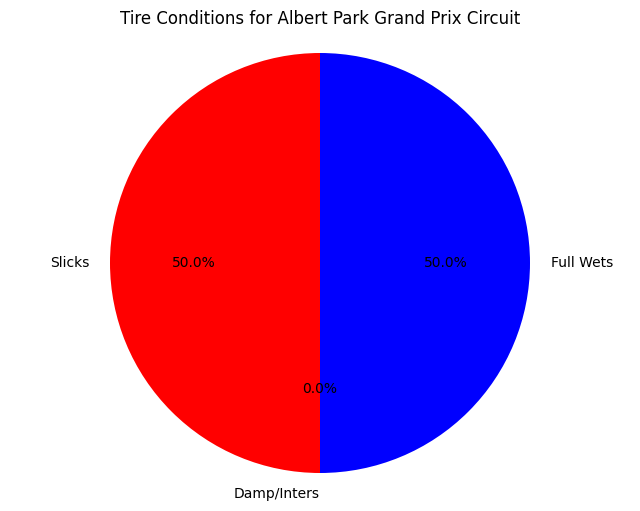

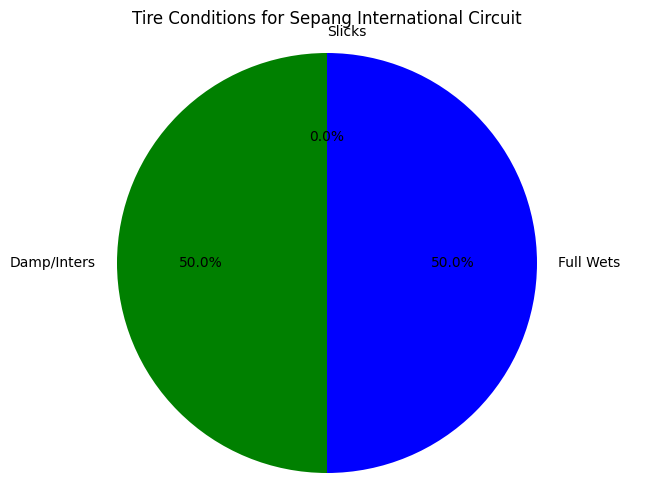

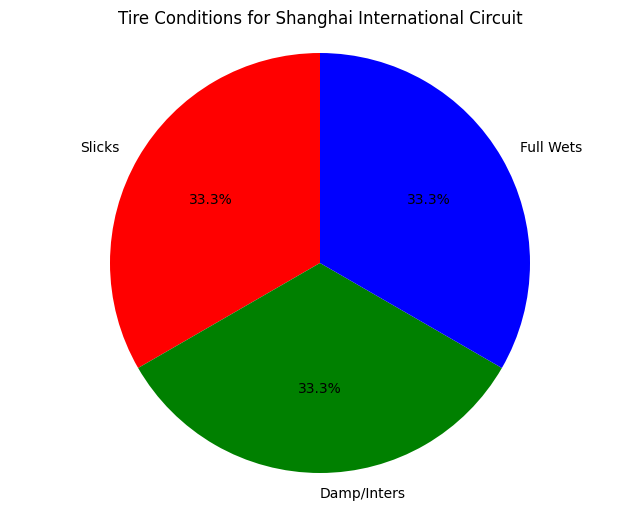

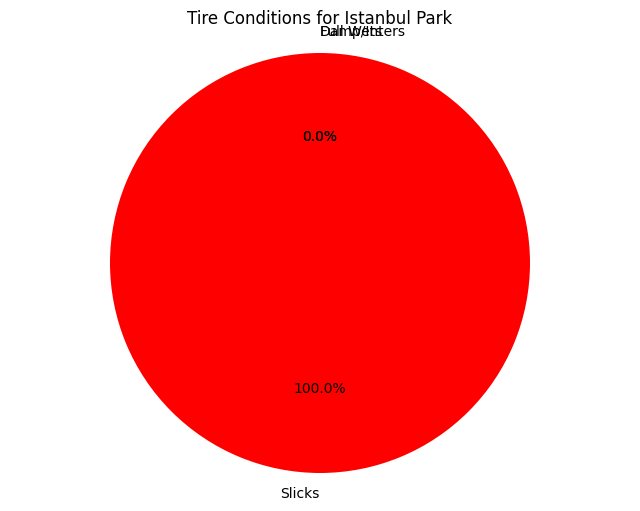

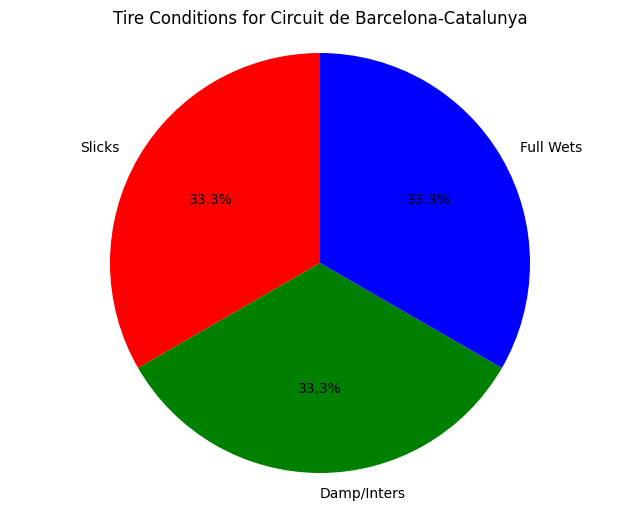

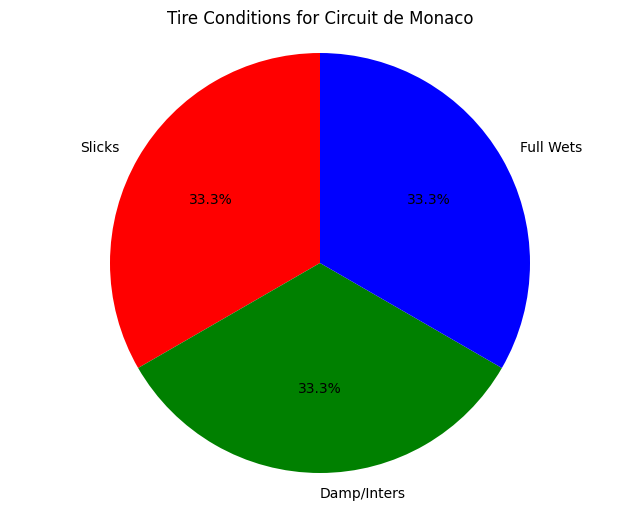

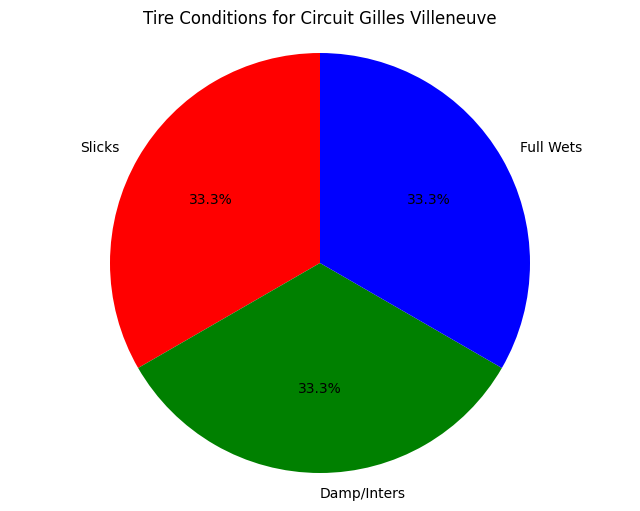

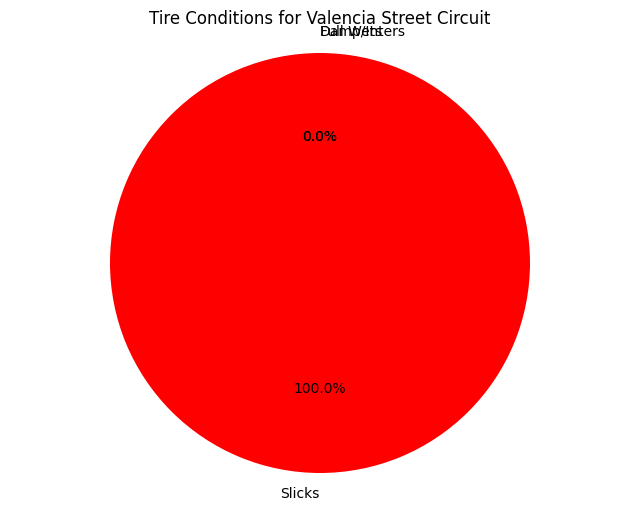

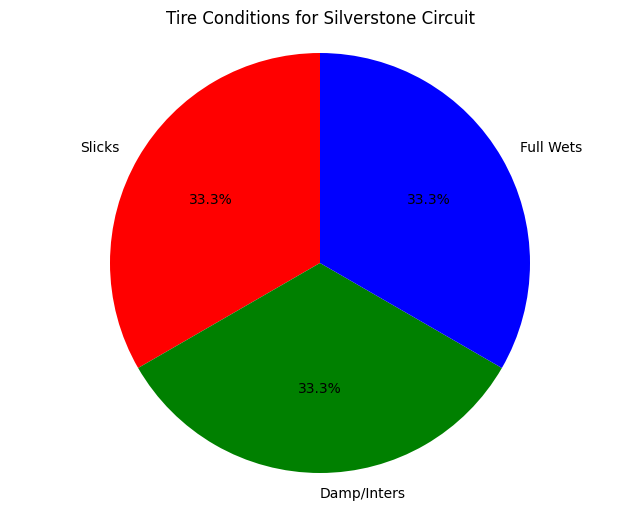

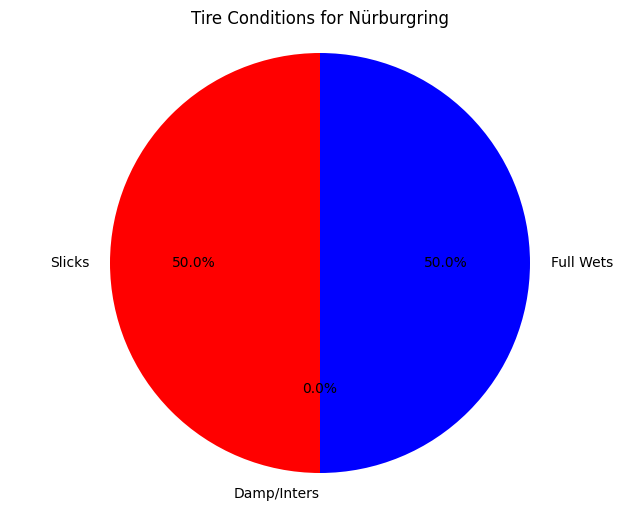

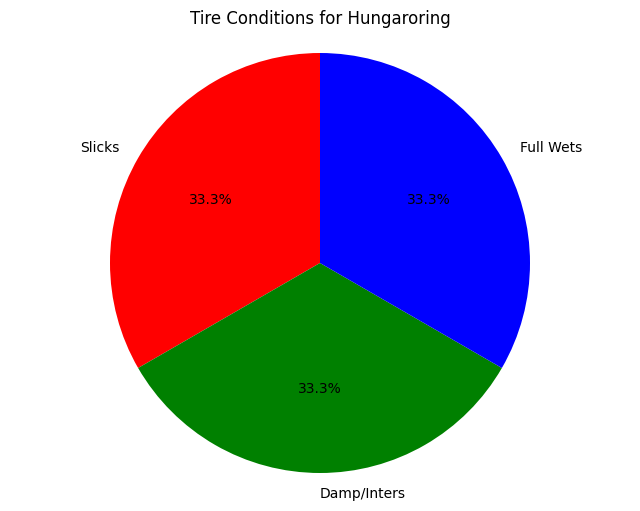

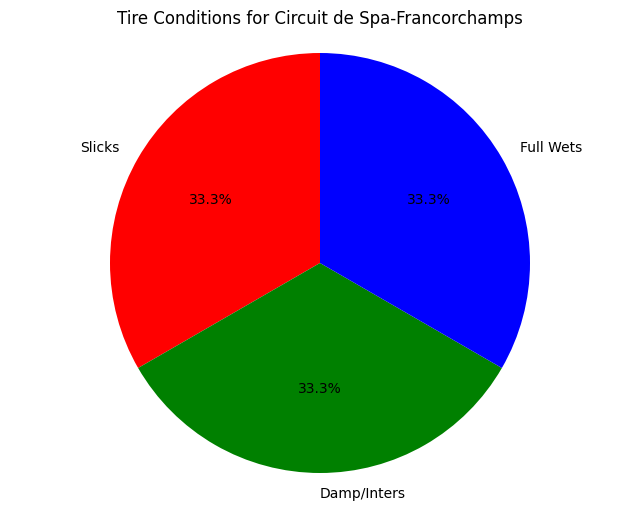

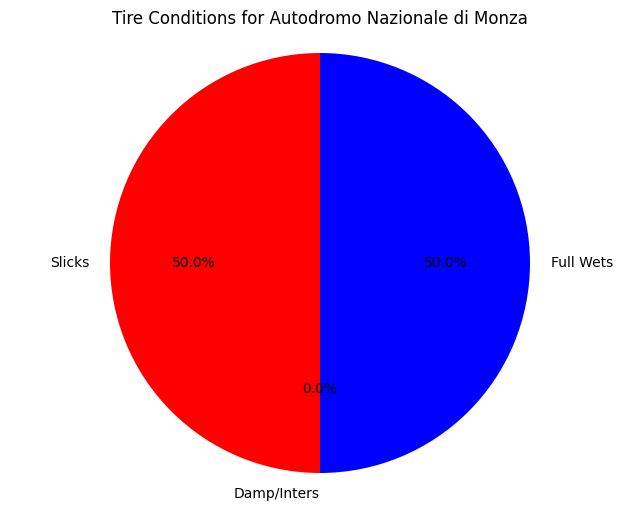

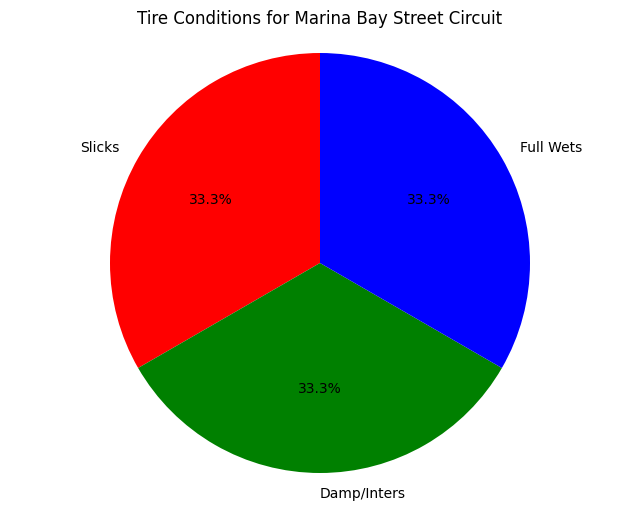

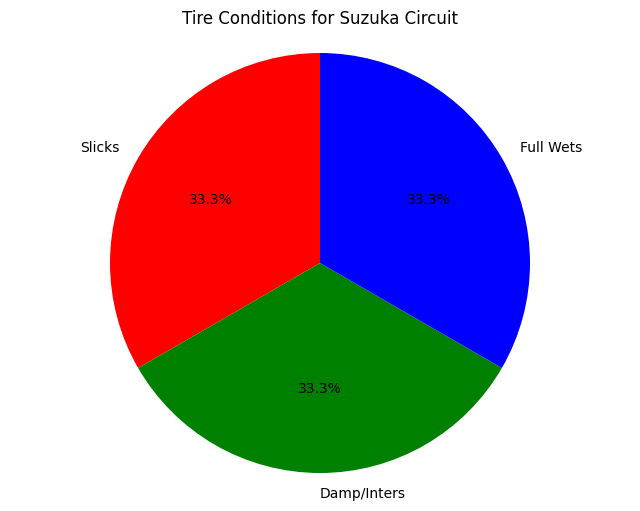

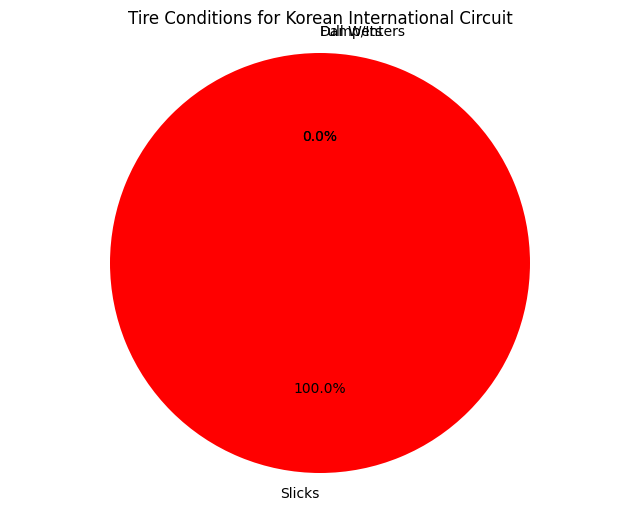

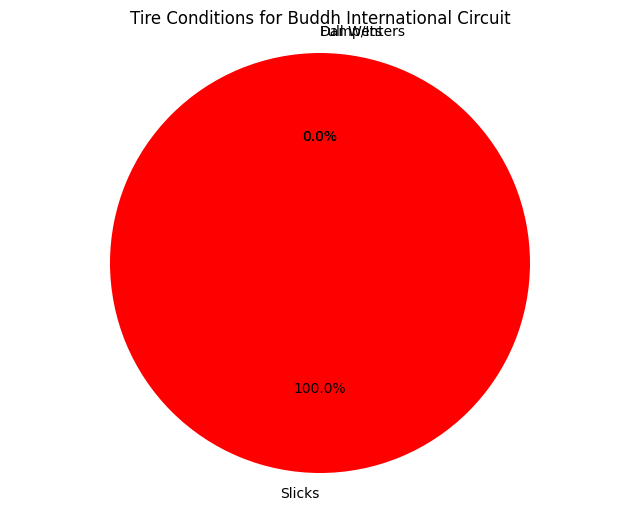

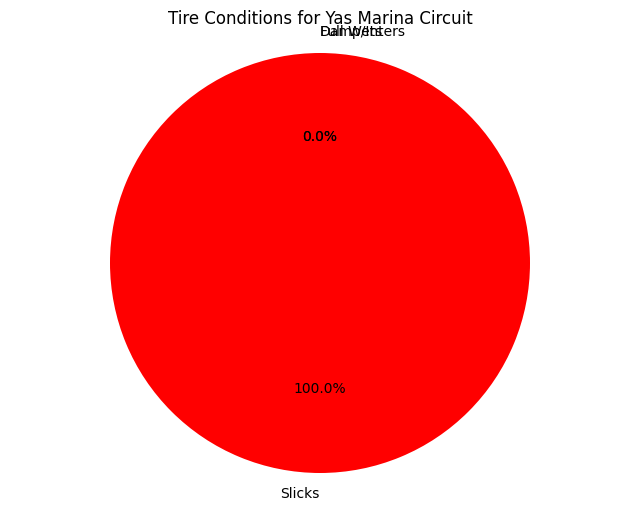

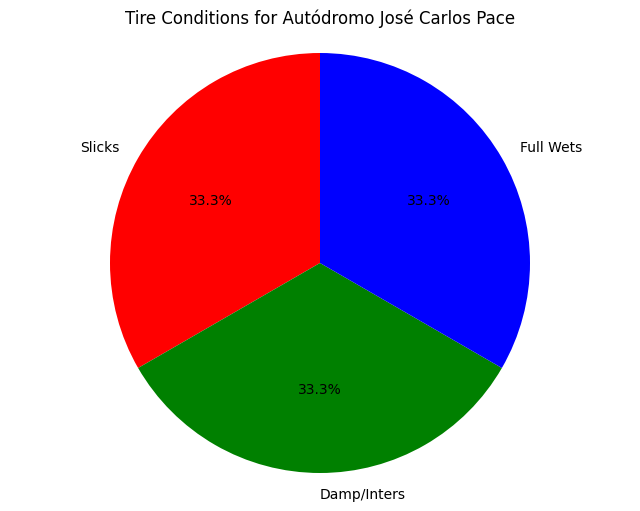

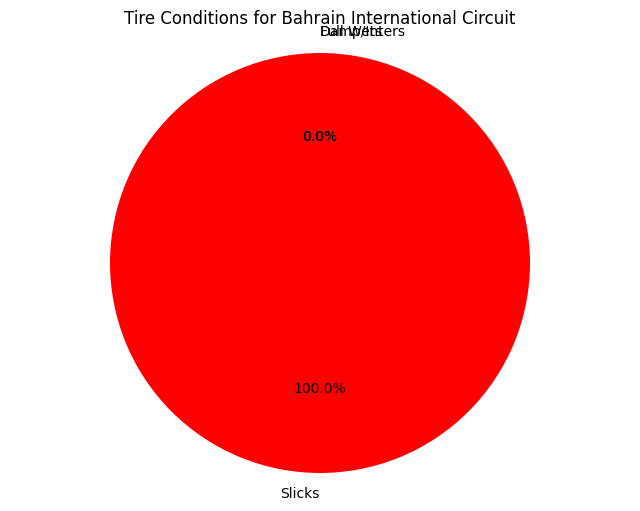

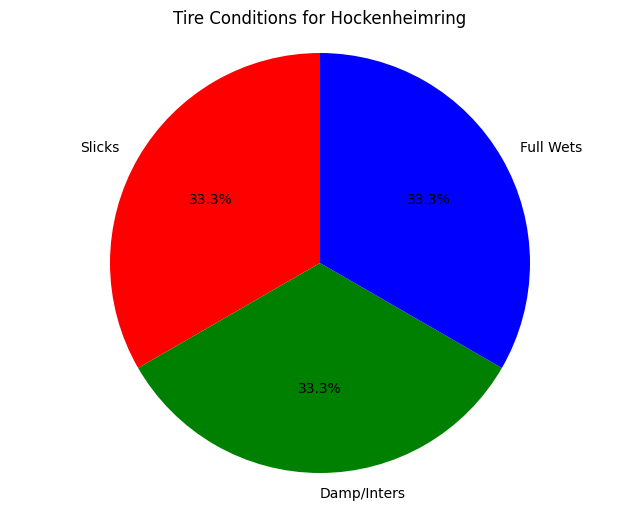

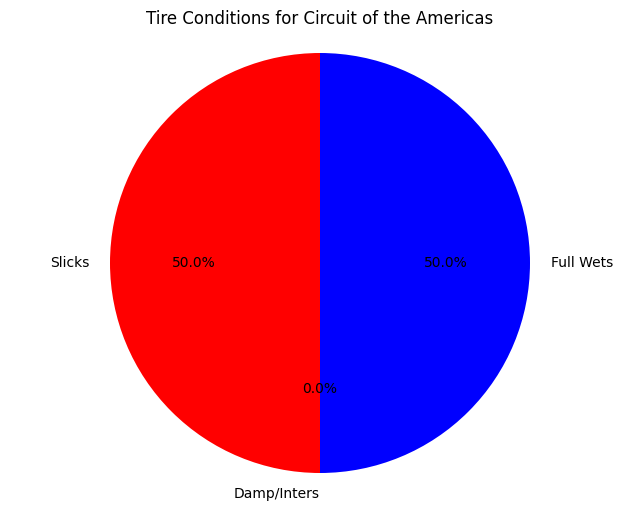

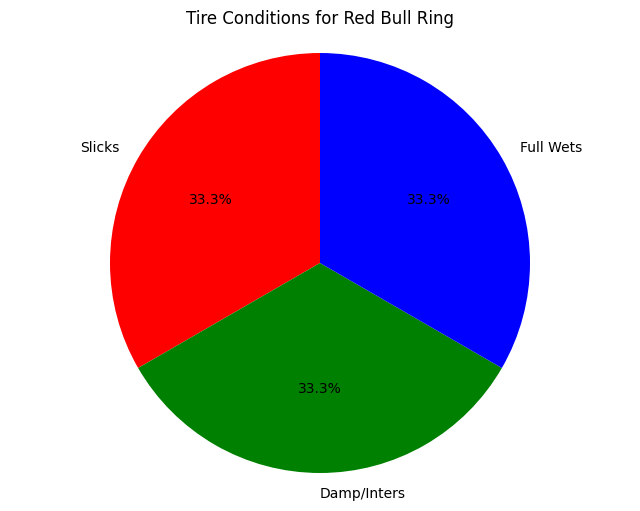

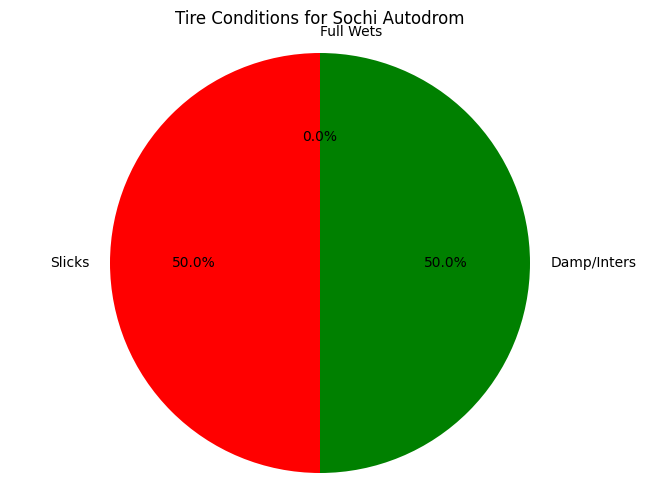

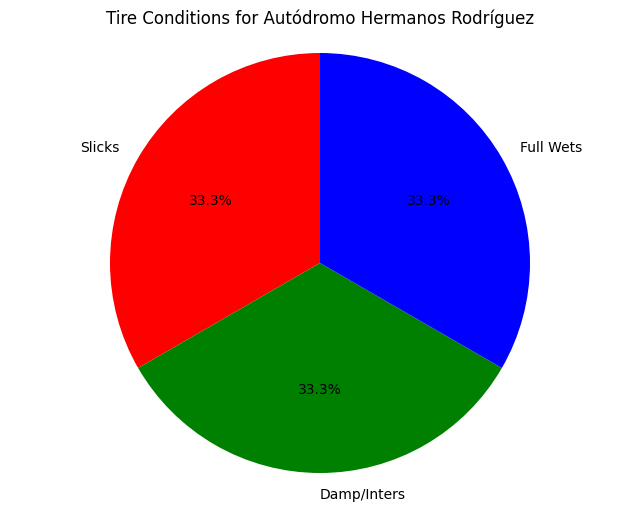

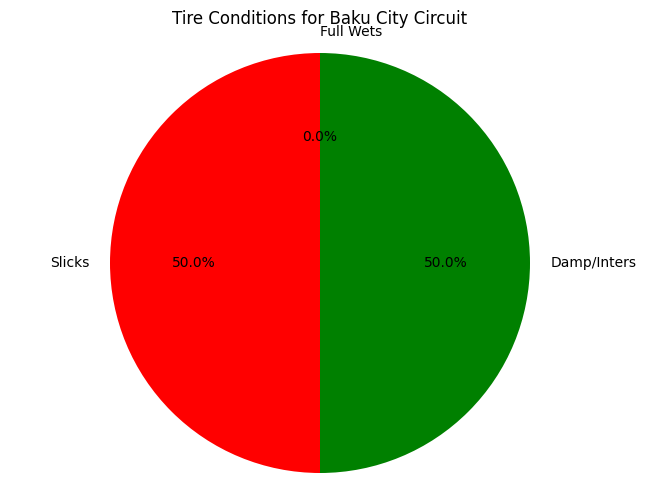

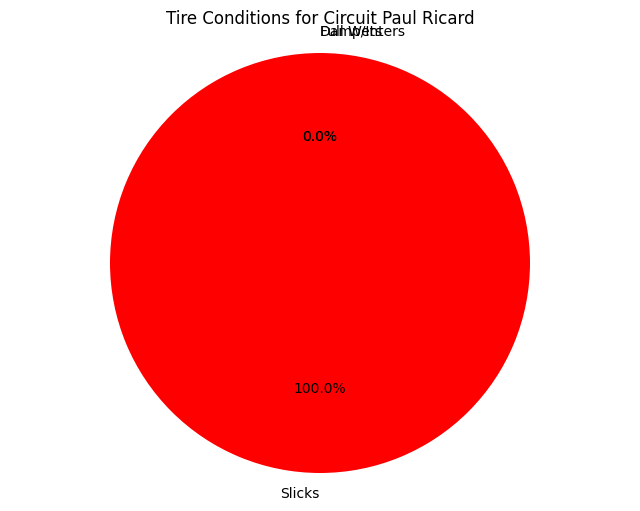

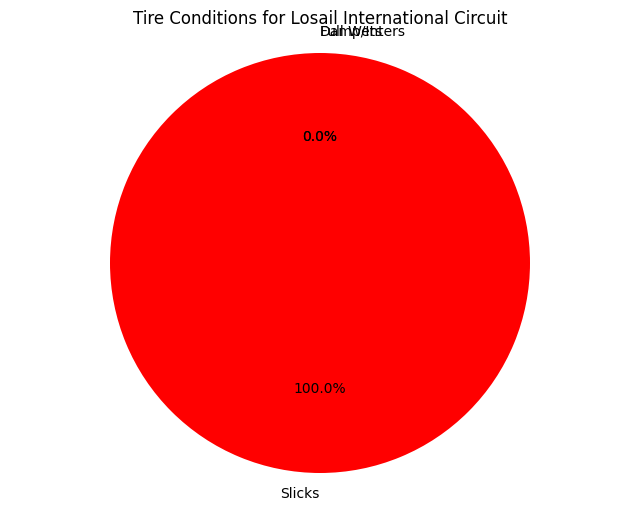

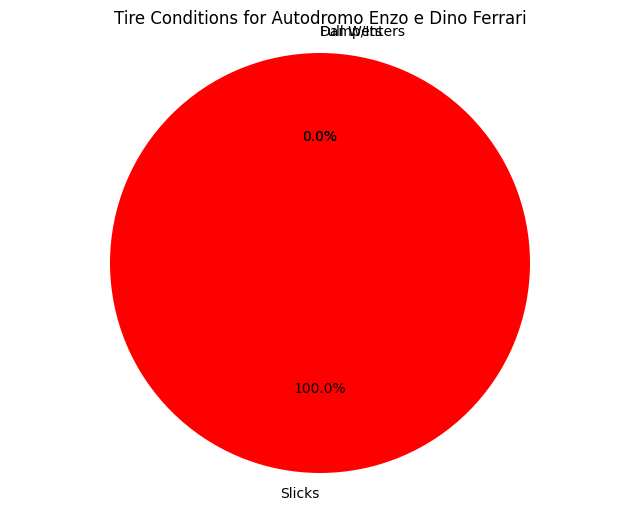

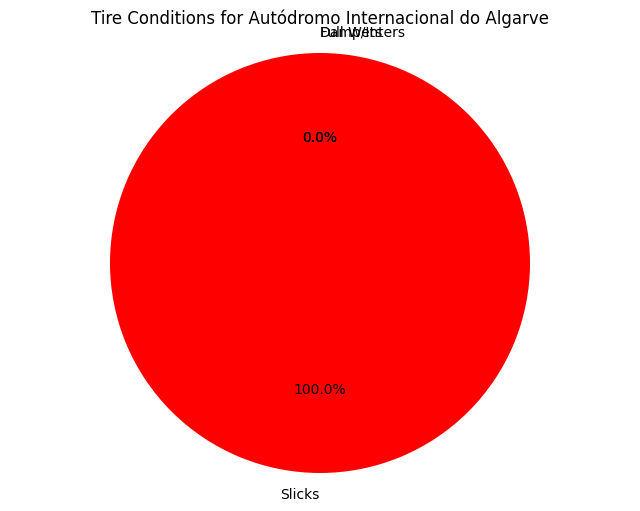

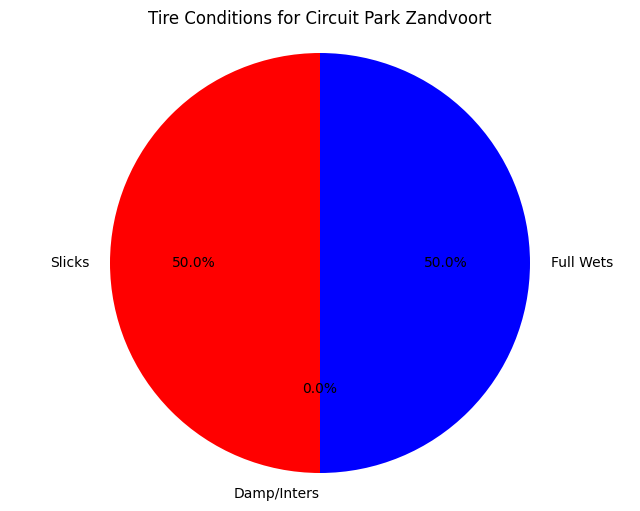

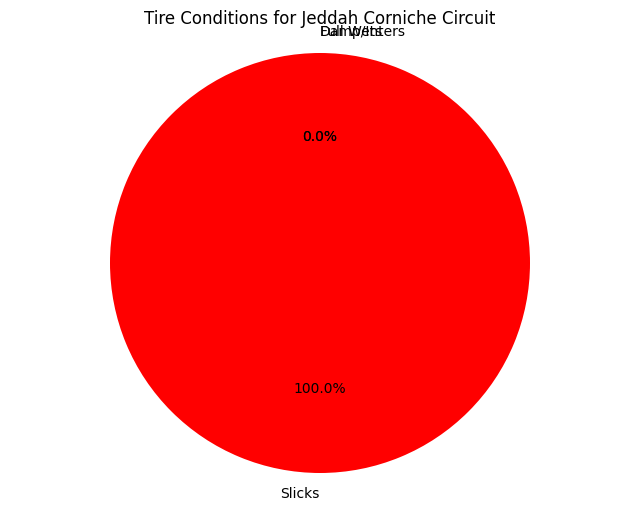

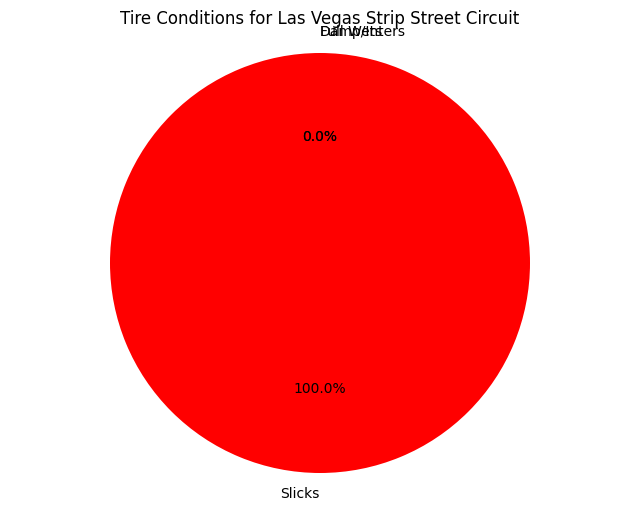

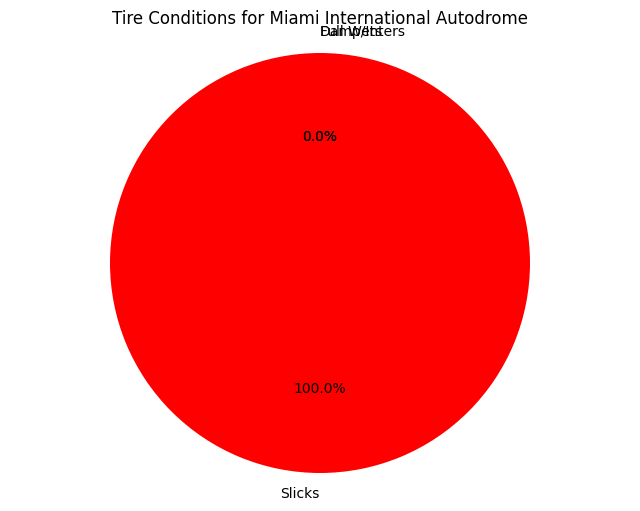

In [ ]:
#Setup Colours
tire_colors = {
    "Slicks": "red",
    "Damp/Inters": "green",
    "Full Wets": "blue"
}

for circuit_name, tire_data in average_pitstops.items():
    tire_counts = { "Slicks": 0, "Damp/Inters": 0, "Full Wets": 0 }
    for tire_type, pitstop_counts in tire_data.items():
        if isinstance(pitstop_counts, list):
            tire_counts[tire_type] = len(pitstop_counts)
        elif isinstance(pitstop_counts, (int, float)):
            tire_counts[tire_type] += 1

    colors = [tire_colors.get(tire_type, "gray") for tire_type in tire_counts.keys()]

    plt.figure(figsize=(8, 6))
    plt.pie(tire_counts.values(), labels=tire_counts.keys(), colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(f"Tire Conditions for {circuit_name}")
    plt.axis('equal')
    plt.show()


This is another simple breakdown of pitstops used since 2011, and while the chart may look slightly wrong in places, most of it can be accounted for. 2011 had issues with tire degradation being too high on all circuits, accounting for the major issue with increased pit stops. 2024 does not have complete data, leading to misleading data. and 2020 had less races due to covid. 2018 and 19 were simply a good year for tires, as Perelli increased the strength of the tires, leading to them lasting longer on track. This was reverted in 2020, but covid cut that season short.

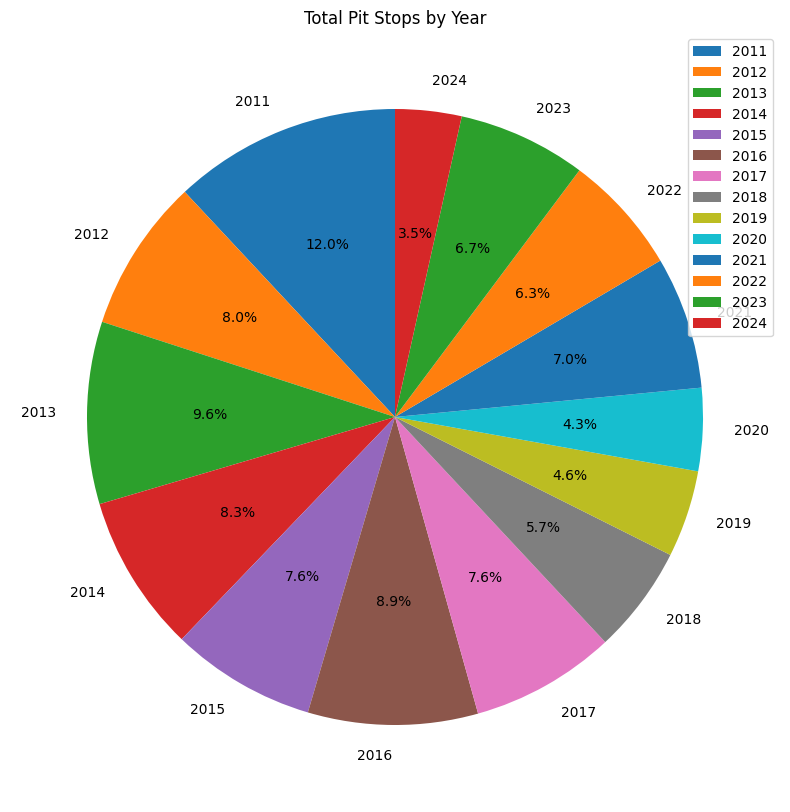

In [ ]:
tire_usage_by_year = max_pitstops_per_race.groupby(['year'])['stop'].sum().reset_index()

tire_usage_by_year.set_index('year', inplace=True)
tire_usage_by_year.plot.pie(y='stop', figsize=(10, 10), autopct='%1.1f%%', startangle=90)

plt.title('Total Pit Stops by Year')
plt.ylabel('')
plt.show()

I then calculated all the tires used in total, before comparing them with a pie chart. This data is not accurate for full wets, as most races would have been called off at this point. However, this can’t be accounted for, as the FIA take these decisions at their own discretion. The other issue with full wets is that many of these races would not have required them except for certain parts of the race, say lap 18-27 need full wets or inters, but by lap 27 the track has dried to slicks. This is once again done on a track-by-track basis, which would require a way to track the data from 2011 to work out exactly which tires were used when. I briefly considered using a screen scraper to watch all races since 2011, but decided against it as it would take too much time and issues with the f1 archive not always showing the tires used on the screens left side.

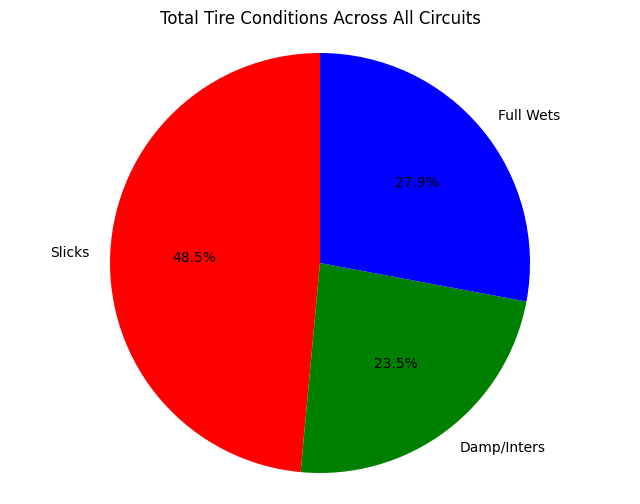

In [ ]:
import matplotlib.pyplot as plt

tire_colors = {
    "Slicks": "red",
    "Damp/Inters": "green",
    "Full Wets": "blue"
}

total_tire_counts = {
    "Slicks": 0,
    "Damp/Inters": 0,
    "Full Wets": 0
}

# Loop through each circuit and tire type data
for circuit_name, tire_data in average_pitstops.items():
    for tire_type, pitstop_counts in tire_data.items():
        if isinstance(pitstop_counts, list):
            # If pitstop_counts is a list, count the number of races (length of list)
            total_tire_counts[tire_type] += len(pitstop_counts)
        elif isinstance(pitstop_counts, (int, float)):
            # If pitstop_counts is a float or integer, count it as one occurrence
            total_tire_counts[tire_type] += 1

# Prepare data for plotting
tire_types = list(total_tire_counts.keys())
tire_counts = list(total_tire_counts.values())

# Set the colors for the pie chart
colors = [tire_colors.get(tire_type, "gray") for tire_type in tire_types]

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(tire_counts, labels=tire_types, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Total Tire Conditions Across All Circuits")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle
plt.show()


This code block is used to predict the number of pit stops to win each circuit in 2024. It was at this point I realised the dataset was not up to date with the most recent races, but I allowed this as a test of theory. It uses liner regression predict pit stops.

In [ ]:
# Convert date columns to datetime objects
max_pitstops_per_race['date'] = pd.to_datetime(max_pitstops_per_race['date']).dt.date
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.date

# Aggregate weather data to daily averages
average_weather_df = (
    weather_df.groupby('date', as_index=False)
    .agg(
        temperature_2m=('avg_temperature_2m', 'mean'),
        rain=('total_rain', 'mean')
    )
)

# Separate historical data and future races to have a comparision. The model predicts 2024
historical_data = max_pitstops_per_race[max_pitstops_per_race['year'] < 2024]
future_races = max_pitstops_per_race[max_pitstops_per_race['year'] == 2024]

# Merge the data
merged_historical_data = pd.merge(historical_data, average_weather_df, on='date', how='inner')
merged_future_races = pd.merge(future_races, average_weather_df, on='date', how='inner')

# Remove duplicate rows from future races to ensure only 1 race is worked with
merged_future_races = merged_future_races.drop_duplicates(subset=['date', 'name_y'])

# Define features for the model and target for the model
features = merged_historical_data[['temperature_2m', 'rain']]
target = merged_historical_data['stop']

# Split data into training data and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Function to predict pit stops of the 2024 season
def predict_pitstops(temperature, rain):
    input_data = pd.DataFrame([[temperature, rain]], columns=['temperature_2m', 'rain'])
    return model.predict(input_data)[0]


# Predict pit stops for the future races dataframe
merged_future_races['predicted_pitstops'] = merged_future_races.apply(
    lambda row: predict_pitstops(row['temperature_2m'], row['rain']), axis=1
)

# Print predictions
for index, row in merged_future_races.iterrows():
    print(f"Race: {row['name_y']}, Year: {row['year']}, Predicted Pit Stops: {row['predicted_pitstops']:.2f}")


Race: Jeddah Corniche Circuit, Year: 2024, Predicted Pit Stops: 1.93
Race: Albert Park Grand Prix Circuit, Year: 2024, Predicted Pit Stops: 2.00
Race: Shanghai International Circuit, Year: 2024, Predicted Pit Stops: 2.01
Race: Miami International Autodrome, Year: 2024, Predicted Pit Stops: 1.92
Race: Autodromo Enzo e Dino Ferrari, Year: 2024, Predicted Pit Stops: 1.98
Race: Circuit de Monaco, Year: 2024, Predicted Pit Stops: 1.98
Race: Circuit Gilles Villeneuve, Year: 2024, Predicted Pit Stops: 2.03
Race: Circuit de Barcelona-Catalunya, Year: 2024, Predicted Pit Stops: 1.98
Race: Red Bull Ring, Year: 2024, Predicted Pit Stops: 1.94
Race: Silverstone Circuit, Year: 2024, Predicted Pit Stops: 2.04


With the predictons made, I used this code block to comapre my predictions to actual races, testing my model.

In [ ]:
# Convert date columns to datetime
max_pitstops_per_race['date'] = pd.to_datetime(max_pitstops_per_race['date']).dt.date
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.date

# Aggregate weather data to daily averages
average_weather_df = weather_df.groupby('date').agg(
    temperature_2m=('avg_temperature_2m', 'mean'),
    rain=('total_rain', 'mean')
).reset_index()

# Separate historical data and future races to have a comparision. The model predicts 2024
historical_data = max_pitstops_per_race[max_pitstops_per_race['year'] < 2024]
future_races = max_pitstops_per_race[max_pitstops_per_race['year'] == 2024]

# Merge the data
merged_historical_data = pd.merge(historical_data, average_weather_df, on='date')
merged_future_races = pd.merge(future_races, average_weather_df, on='date').drop_duplicates(subset=['date', 'name_y'])

# Define features for the model and target for the model
X = merged_historical_data[['temperature_2m', 'rain']]
y = merged_historical_data['stop']

# Split data into training data and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict pit stops for future races
merged_future_races['predicted_pitstops'] = merged_future_races.apply(
    lambda row: model.predict(pd.DataFrame([[row['temperature_2m'], row['rain']]], columns=['temperature_2m', 'rain']))[0], axis=1
)

# Merge with actual pit stops data for 2024
merged_future_races_actual = pd.merge(merged_future_races, max_pitstops_per_race[['raceId', 'stop']], on='raceId', how='left')

# Get the actual pit stops and predicted pit stops
actual_pitstops = merged_future_races_actual['stop_y'].values  # 'stop_y' after merging
predicted_pitstops = merged_future_races_actual['predicted_pitstops'].values

# Calculate and print error metrics (MSE.RMSE,R²)
mse = mean_squared_error(actual_pitstops, predicted_pitstops)
rmse = np.sqrt(mse)
r2 = r2_score(actual_pitstops, predicted_pitstops)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Squared Error (MSE): 0.3628
Root Mean Squared Error (RMSE): 0.6023
R-squared (R²): -0.5117


This result is obviously less than ideal, as my model is inaccurate. Lower MSE is better, Lower MRSE is better and you want R-squared to be a as close to one as possible. Given this, I decided to try a different algorithm, although I believe there may be a different reason for the issues.

For this prediction model, I used G-Boost, hoping its repetitive nature would allow it to be more accurate.

In [ ]:
# Convert date columns to datetime
max_pitstops_per_race['date'] = pd.to_datetime(max_pitstops_per_race['date']).dt.date
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.date

# Aggregate weather data to daily averages
average_weather_df = weather_df.groupby('date').agg(
    temperature_2m=('avg_temperature_2m', 'mean'),
    rain=('total_rain', 'mean')
).reset_index()

# Split data into historical and future races
historical_data = max_pitstops_per_race[max_pitstops_per_race['year'] < 2024]
future_races = max_pitstops_per_race[max_pitstops_per_race['year'] == 2024]

# Merge weather data
merged_historical_data = pd.merge(historical_data, average_weather_df, on='date')
merged_future_races = pd.merge(future_races, average_weather_df, on='date').drop_duplicates(subset=['date', 'name_y'])

# Define features and target
X = merged_historical_data[['temperature_2m', 'rain']]
y = merged_historical_data['stop']

# Split and train the Gradient Boosting model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
model = GradientBoostingRegressor(random_state=5)
model.fit(X_train, y_train)

# Predict pit stops for future races
merged_future_races['predicted_pitstops'] = merged_future_races.apply(
    lambda row: model.predict(pd.DataFrame([[row['temperature_2m'], row['rain']]], columns=['temperature_2m', 'rain']))[0], axis=1
)

# Merge with actual pit stops data for 2024
merged_future_races_actual = pd.merge(merged_future_races, max_pitstops_per_race[['raceId', 'stop']], on='raceId', how='left')

# Get the actual pit stops and predicted pit stops
actual_pitstops = merged_future_races_actual['stop_y'].values
predicted_pitstops = merged_future_races_actual['predicted_pitstops'].values

# Calculate and print error metrics
mse = mean_squared_error(actual_pitstops, predicted_pitstops)
rmse = np.sqrt(mse)
r2 = r2_score(actual_pitstops, predicted_pitstops)

# Calculate and print error metrics (MSE.RMSE,R²)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Squared Error (MSE): 0.3364
Root Mean Squared Error (RMSE): 0.5800
R-squared (R²): -0.4015


As clearly seen, this did not work at all, every result being less accurate than the previous model. I think this is as a result of overfitting, due to the limited data available per circuit. As for the model inaccuracy, the 2024 f1 championship has been a battle, with multiple safety cars deployed, which many teams will make use of "cheap" pit stop, adding pit stops to a already limited set of data. Despite the huge number of races taking place since 2011, about 237 excluding 2024 data, there’s only in the best cases about 13 races worth of data for each race and at worst 2. The technical changes over the years also make some data more useful than others. Given this, I decided to try weighting the data by year, giving more weight to races since 2020 as the technical regulations have not changed a huge amount since then

In [ ]:
merged_historical_data['weight'] = merged_historical_data['year'].apply(lambda x: 3 if x >= 2020 else (1 if x != 2021 else 5))

# Define features, target, and weights
features = merged_historical_data[['temperature_2m', 'rain']]
target = merged_historical_data['stop']
weights = merged_historical_data['weight']

# Split data into training and testing sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    features, target, weights, test_size=0.2, random_state=42
)

# Train the model with sample weights
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=weights_train)

# Evaluate model performance on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Function to predict pit stops
def predict_pitstops(temperature, rain):
    input_data = pd.DataFrame([[temperature, rain]], columns=['temperature_2m', 'rain'])
    return model.predict(input_data)[0]

# Predict pit stops for future races
merged_future_races['predicted_pitstops'] = merged_future_races.apply(
    lambda row: predict_pitstops(row['temperature_2m'], row['rain']), axis=1
)

# Print predictions for each race
print("\nPredictions for Future Races:")
for index, row in merged_future_races.iterrows():
    print(f"Race: {row['name_y']}, Year: {row['year']}, Predicted Pit Stops: {row['predicted_pitstops']:.2f}")

Mean Squared Error (MSE): 0.6435
Root Mean Squared Error (RMSE): 0.8022
R-squared (R²): -0.0347

Predictions for Future Races:
Race: Jeddah Corniche Circuit, Year: 2024, Predicted Pit Stops: 1.89
Race: Albert Park Grand Prix Circuit, Year: 2024, Predicted Pit Stops: 2.05
Race: Shanghai International Circuit, Year: 2024, Predicted Pit Stops: 2.06
Race: Miami International Autodrome, Year: 2024, Predicted Pit Stops: 1.85
Race: Autodromo Enzo e Dino Ferrari, Year: 2024, Predicted Pit Stops: 2.00
Race: Circuit de Monaco, Year: 2024, Predicted Pit Stops: 2.01
Race: Circuit Gilles Villeneuve, Year: 2024, Predicted Pit Stops: 2.07
Race: Circuit de Barcelona-Catalunya, Year: 2024, Predicted Pit Stops: 1.99
Race: Red Bull Ring, Year: 2024, Predicted Pit Stops: 1.91
Race: Silverstone Circuit, Year: 2024, Predicted Pit Stops: 2.15


This is the most accurate model so far, but still isn’t accurate. I gave 2021 more weight as it had the most competitive season since 2020, better emulating the 2024 F1 season, although at a higher intensity than the current one. Its accuracy is still not great, it is improving. I think the biggest issue with the accuracy is the lack of data, as each circuit has a maximum of 13 race sin the dataset. While this is frustrating, it’s an issue that is incredibly difficult to fix without any elementary data from a F1 Car, as well as these kinds of models being entirely unable to react to on track conditions. This is why F1 Teams don’t rely on this kind of data heavily, as on track conditions such as weather or a safety car, minor car damage, or a red flag throw spanners in these plans every race. If I had more time to work on this project, all F1 Tracks have been Lidar Scanned, and it would in theory be possible to create a model for each track to show expected tire degradation. This could be a good topic for a final year project in 4th year, but in the time allotted for this module, it would be almost impossible. Overall I’m happy with the project, but believe if I was to redo it I would have chosen a different research question, as predicting pitstops with no way of reacting to on track incidents is a borderline impossible task